d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


正确分类样本数: 501
误分类样本数: 499


C:\Users\Administrator\AppData\Local\Temp\ipykernel_45164\623217349.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_correct, x='Frequency', y='Word', ax=axes[0], palette='Blues_r')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_45164\623217349.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_misclassified, x='Frequency', y='Word', ax=axes[1], palette='Reds_r')


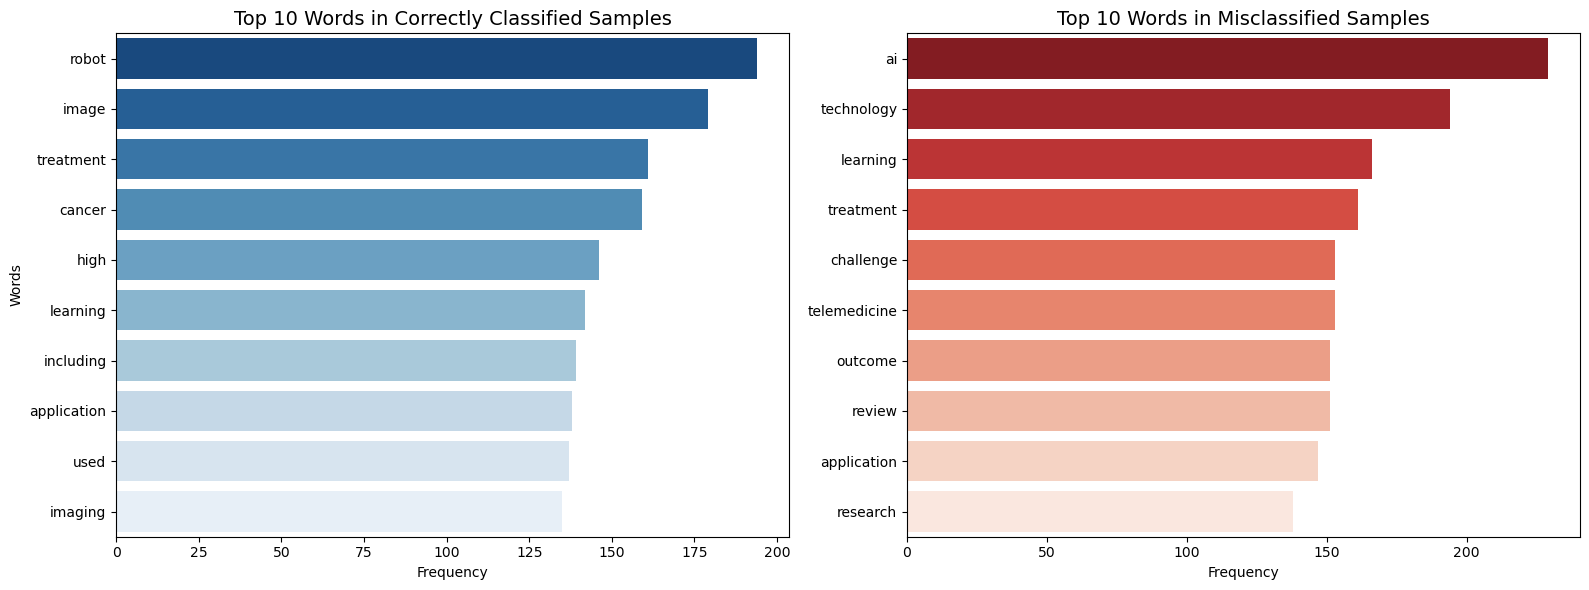


=== 关键词分析结果 ===
正确分类样本 Top 10 词汇: high, robot, learning, treatment, image, cancer, used, application, imaging, including
误分类样本 Top 10 词汇: learning, treatment, review, telemedicine, research, outcome, application, technology, challenge, ai

=== 潜在的“噪音词” (存在于误分类Top10，但不在正确分类Top10中) ===
-> review, telemedicine, research, outcome, technology, challenge, ai
分析: 这些词可能在不同类别中都有出现，缺乏区分度，导致模型产生混淆。

=== 共同高频词 (同时存在于两者的Top10中) ===
-> learning, treatment, application
分析: 这些词是整个数据集的背景词汇。如果在聚类时没有被作为停用词去除，可能会干扰聚类效果。


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# ----------------- 1. Reproduce K-means(Custom Stopwords+LSA) Clustering Results -----------------
df = pd.read_csv('../processed_data.csv')
docs = df['Cleaned_Content'].fillna('').str.replace(r'\bpad\b', '', regex=True).tolist()
true_labels = df['Label'].tolist()

unique_labels = sorted(list(set(true_labels)))
label_to_id = {l: i for i, l in enumerate(unique_labels)}
y_true = np.array([label_to_id[l] for l in true_labels])

# Use the same custom stop words as K-means(Custom Stopwords+LSA)
custom_stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + \
                    [ 'disease', 'medical', 'patient', 'data', 'study', 'health', 'method', 'model',
                     'clinical', 'based', 'using', 'healthcare', 'care', 'result', 'analysis']

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=custom_stop_words, max_df=0.6, min_df=5)
X_tfidf = tfidf_vectorizer.fit_transform(docs)

n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_lsa = svd.fit_transform(X_tfidf)

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
y_pred_clusters = kmeans.fit_predict(X_lsa)

# Label matching
def match_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    mapping = {col: row for col, row in zip(col_ind, row_ind)}
    y_pred_matched = [mapping[l] for l in y_pred]
    return np.array(y_pred_matched)

y_pred_matched = match_labels(y_true, y_pred_clusters)

# ----------------- 2. Split Correctly Classified and Misclassified Samples -----------------
correct_mask = y_true == y_pred_matched
misclassified_mask = y_true != y_pred_matched

docs_correct = np.array(docs)[correct_mask]
docs_misclassified = np.array(docs)[misclassified_mask]

print(f"Number of correctly classified samples: {len(docs_correct)}")
print(f"Number of misclassified samples: {len(docs_misclassified)}")

# ----------------- 3. Extract Top 10 Keywords -----------------
# Previously we only used basic english stop words, resulting in common high-frequency words for the entire dataset.
# Now we use the same custom_stop_words as in clustering, so the extracted words better reflect the "feature words" causing misclassification.
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words=custom_stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top_correct = get_top_n_words(docs_correct, 10)
top_misclassified = get_top_n_words(docs_misclassified, 10)

df_correct = pd.DataFrame(top_correct, columns=['Word', 'Frequency'])
df_misclassified = pd.DataFrame(top_misclassified, columns=['Word', 'Frequency'])

# ----------------- 4. Visual Comparison -----------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df_correct, x='Frequency', y='Word', ax=axes[0], palette='Blues_r')
axes[0].set_title('Top 10 Words in Correctly Classified Samples', fontsize=14)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')

sns.barplot(data=df_misclassified, x='Frequency', y='Word', ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 10 Words in Misclassified Samples', fontsize=14)
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# ----------------- 5. Find "Noise Words" -----------------
correct_words = set(df_correct['Word'])
misclassified_words = set(df_misclassified['Word'])

noise_words = misclassified_words - correct_words
common_words = misclassified_words.intersection(correct_words)

print("\n=== Keyword Analysis Results ===")
print(f"Top 10 words in correctly classified samples: {', '.join(correct_words)}")
print(f"Top 10 words in misclassified samples: {', '.join(misclassified_words)}")

print("\n=== Potential 'Noise Words' (Present in misclassified Top 10, but not in correct Top 10) ===")
if noise_words:
    print(f"-> {', '.join(noise_words)}")
    print("Analysis: These words may appear in different categories, lacking discriminative power, causing model confusion.")
else:
    print("-> No obvious difference words.")

print("\n=== Common High-Frequency Words (Present in both Top 10s) ===")
print(f"-> {', '.join(common_words)}")
print("Analysis: These words are background vocabulary for the entire dataset. If not removed as stop words during clustering, they may interfere with clustering performance.")

在 499 个误分类样本中，有 81 个包含了 'telemedicine'。

包含 'telemedicine' 的误分类样本的真实标签分布：
True Label
telemedicine                 74
electronic health records     2
medical imaging               2
precision medicine            2
healthcare robotics           1
Name: count, dtype: int64

包含 'telemedicine' 的误分类样本被错误预测成了哪些类别：
Predicted Label
healthcare robotics          40
electronic health records    31
medical imaging               6
precision medicine            3
telemedicine                  1
Name: count, dtype: int64


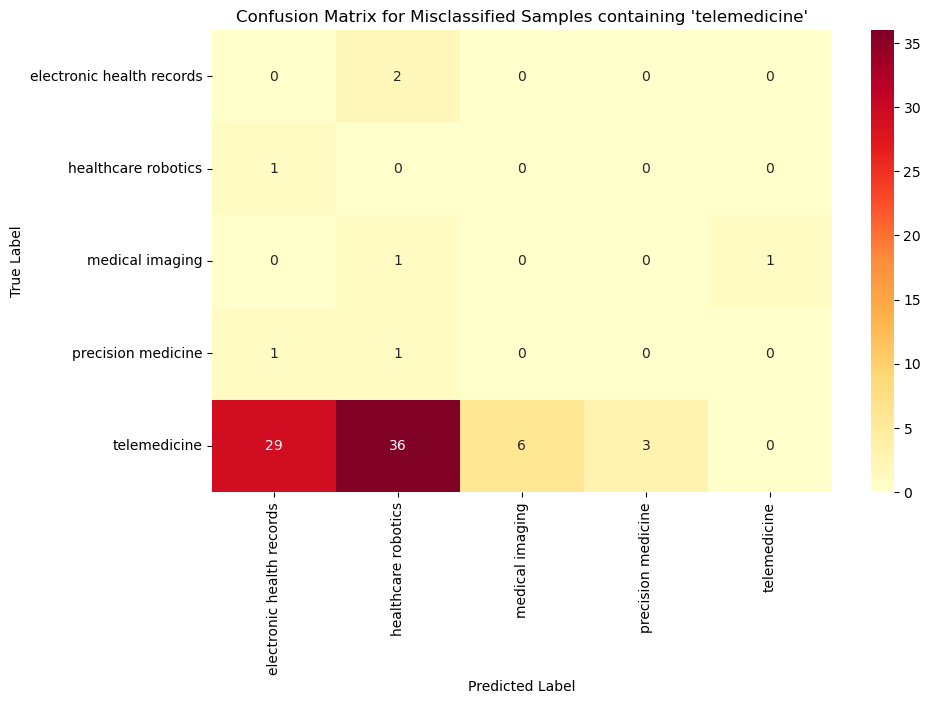

In [ ]:
# ----------------- 6. In-depth Analysis of Telemedicine Misclassification -----------------
# Find all misclassified samples containing "telemedicine"
telemedicine_misclassified_indices = []
for i, doc in enumerate(docs_misclassified):
    if 'telemedicine' in doc.lower():
        telemedicine_misclassified_indices.append(i)

print(f"Out of {len(docs_misclassified)} misclassified samples, {len(telemedicine_misclassified_indices)} contain 'telemedicine'.")

# What were the original true labels of these misclassified samples containing 'telemedicine'?
# We need to map back from docs_misclassified to the original df
misclassified_original_indices = np.where(misclassified_mask)[0]

telemedicine_true_labels = []
telemedicine_pred_labels = []

for idx in telemedicine_misclassified_indices:
    original_idx = misclassified_original_indices[idx]
    true_label = unique_labels[y_true[original_idx]]
    pred_label = unique_labels[y_pred_matched[original_idx]]
    telemedicine_true_labels.append(true_label)
    telemedicine_pred_labels.append(pred_label)

df_tele_analysis = pd.DataFrame({
    'True Label': telemedicine_true_labels,
    'Predicted Label': telemedicine_pred_labels
})

print("\nTrue label distribution of misclassified samples containing 'telemedicine':")
print(df_tele_analysis['True Label'].value_counts())

print("\nCategories that misclassified samples containing 'telemedicine' were incorrectly predicted as:")
print(df_tele_analysis['Predicted Label'].value_counts())

# Plot heatmap to view specific confusion
plt.figure(figsize=(10, 6))
tele_confusion = pd.crosstab(df_tele_analysis['True Label'], df_tele_analysis['Predicted Label'])
sns.heatmap(tele_confusion, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Confusion Matrix for Misclassified Samples containing 'telemedicine'")
plt.show()

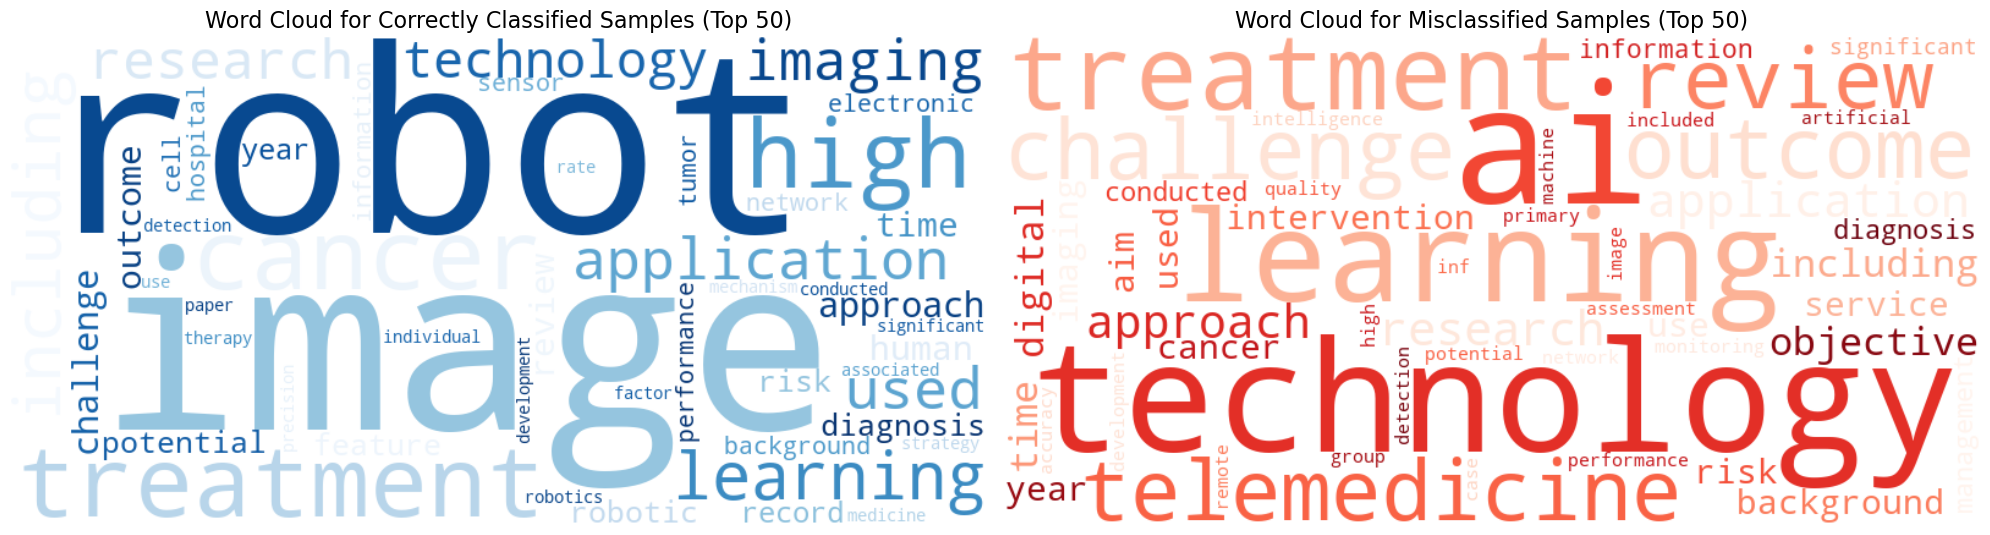

In [ ]:
# ----------------- 7. Draw Word Cloud -----------------
from wordcloud import WordCloud

# To show more words in the word cloud, we need to get Top N word frequencies again, this time we take Top 50
top_n_for_cloud = 50
top_correct_cloud = get_top_n_words(docs_correct, top_n_for_cloud)
top_misclassified_cloud = get_top_n_words(docs_misclassified, top_n_for_cloud)

# Convert to dictionary format {word: frequency}
freq_dict_correct = dict(top_correct_cloud)
freq_dict_misclassified = dict(top_misclassified_cloud)

# Create WordCloud objects
wordcloud_correct = WordCloud(width=800, height=400, background_color='white', 
                              colormap='Blues', prefer_horizontal=0.8, max_words=top_n_for_cloud)
wordcloud_correct.generate_from_frequencies(freq_dict_correct)

wordcloud_misclassified = WordCloud(width=800, height=400, background_color='white', 
                                    colormap='Reds', prefer_horizontal=0.8, max_words=top_n_for_cloud)
wordcloud_misclassified.generate_from_frequencies(freq_dict_misclassified)

# Plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wordcloud_correct, interpolation='bilinear')
axes[0].set_title(f'Word Cloud for Correctly Classified Samples (Top {top_n_for_cloud})', fontsize=16)
axes[0].axis('off')

axes[1].imshow(wordcloud_misclassified, interpolation='bilinear')
axes[1].set_title(f'Word Cloud for Misclassified Samples (Top {top_n_for_cloud})', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()